In [16]:
!pip install tensorflow
!pip install keras
!pip install Sequential

In [17]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

Data Preprocessing

In [18]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.
x_train = np.reshape(x_train,(60000,784))
x_test = np.reshape(x_test,(10000,784))


Adding Noise

In [19]:
noise_train = np.random.rand(*x_train.shape) * 0.9
noise_test = np.random.rand(*x_test.shape) * 0.9

x_train_noisy = x_train + noise_train
x_test_noisy = x_test + noise_test

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

In [20]:
def plot(x,p, labels=False):
  plt.figure(figsize=(20,2))
  for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x[i].reshape(28,28),cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if labels:
      plt.xlabel(np.argmax(p[i]))
  plt.show()
  return
  plot(x_train,None)

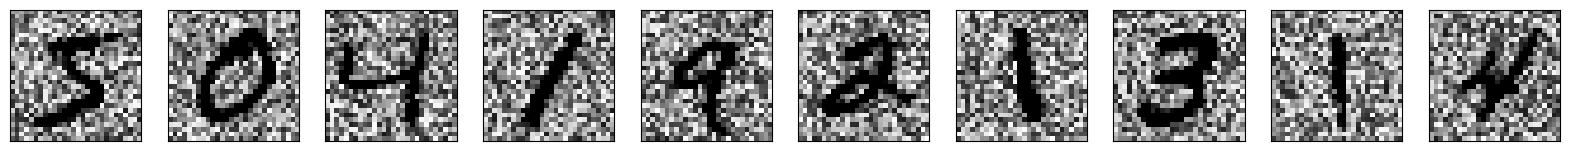

In [21]:
plot(x_train_noisy,None)

Building and Training a Classifier

In [22]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])


classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=3, batch_size=512)

Epoch 1/3
118/118 [==============================] - 4s 20ms/step - loss: 0.4336 - accuracy: 0.8814
Epoch 2/3
118/118 [==============================] - 3s 25ms/step - loss: 0.1564 - accuracy: 0.9550
Epoch 3/3
118/118 [==============================] - 5s 40ms/step - loss: 0.1090 - accuracy: 0.9676


In [23]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (60000, 784)
y_train shape: (60000,)


In [24]:
loss,acc= classifier.evaluate(x_test,y_test)
print(acc)

313/313 [==============================] - 3s 8ms/step - loss: 0.1024 - accuracy: 0.9683
0.9682999849319458


In [25]:
loss,acc= classifier.evaluate(x_test_noisy,y_test)
print(acc)

313/313 [==============================] - 1s 3ms/step - loss: 11.1225 - accuracy: 0.1082
0.10819999873638153


Building the Autoencoder

In [28]:
input_image=Input(shape=(784,))
encoded=Dense(64,activation='relu')(input_image)
decoded=Dense(784,activation='sigmoid')(encoded)

autoencoder=Model(input_image,decoded)
autoencoder.compile(loss='binary_crossentropy',optimizer='adam')


ValueError: ignored

Training the Autoncoder

In [32]:
autoencoder.fit(
    x_train_noisy,x_train,
    epochs=100,batch_size=512,
    validation_split=0.2,verbose=False,
    callbacks=[
        EarlyStopping(monitor='val_loss',patience=5),
        LambdaCallback(on_epoch_end=lambda e,l:print('{:,.3f}'.format(l['val_loss']),end='__'))

      ]
  )

print('_')
print('Training is complete!')

0.172__0.162__0.154__0.147__0.141__0.137__0.133__0.129__0.126__0.124__0.121__0.119__0.118__0.116__0.115__0.114__0.113__0.112__0.111__0.110__0.110__0.109__0.109__0.108__0.108__0.108__0.107__0.107__0.107__0.107__0.107__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.106__0.105__0.106__0.105__0.106__0.105__0.106__0.105__0.105__0.105__0.105___
Training is complete!


Denoised Images

In [33]:
preds=autoencoder.predict(x_test_noisy)

313/313 [==============================] - 1s 2ms/step


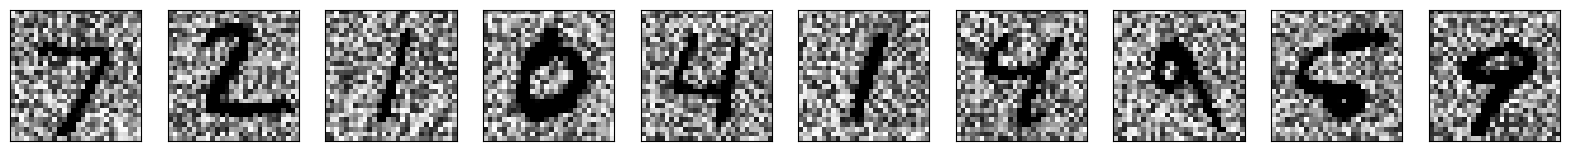

In [34]:
plot(x_test_noisy,None)

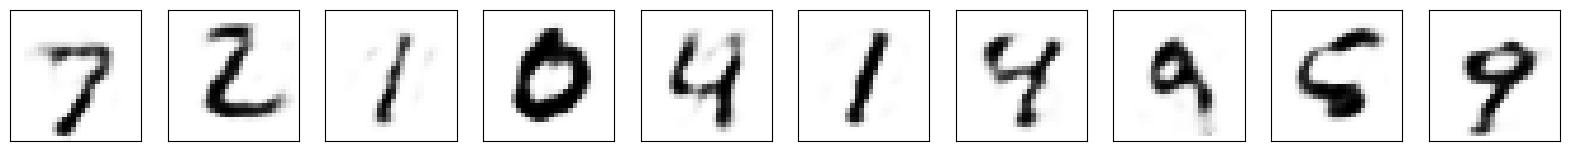

In [35]:
plot(preds,None)

In [37]:
loss,acc=classifier.evaluate(preds,y_test)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1657 - accuracy: 0.9466
0.9466000199317932


Composite Model

In [38]:
input_image=Input(shape=(784,))
x=autoencoder(input_image)
y= classifier(x)
denoise_and_classify= Model(input_image,y)

In [39]:
predictions=denoise_and_classify.predict(x_test_noisy)

313/313 [==============================] - 1s 3ms/step


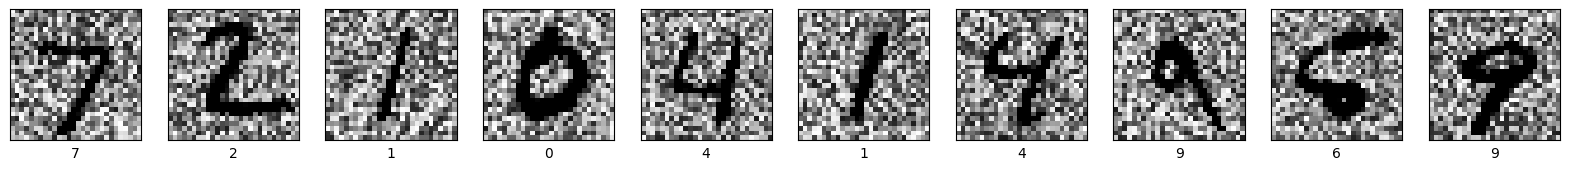

In [40]:
plot(x_test_noisy,predictions,True)

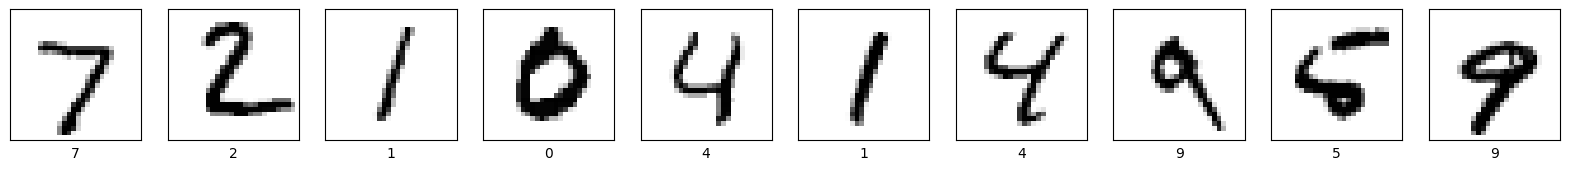

In [41]:
plot(x_test,to_categorical(y_test),True)